<h2>Installations</h2>

In [5]:
# !pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

<h2>Set Vars</h2>

In [19]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

Please provide your LANGCHAIN_API_KEY ········


<h1>Create Agents</h2>

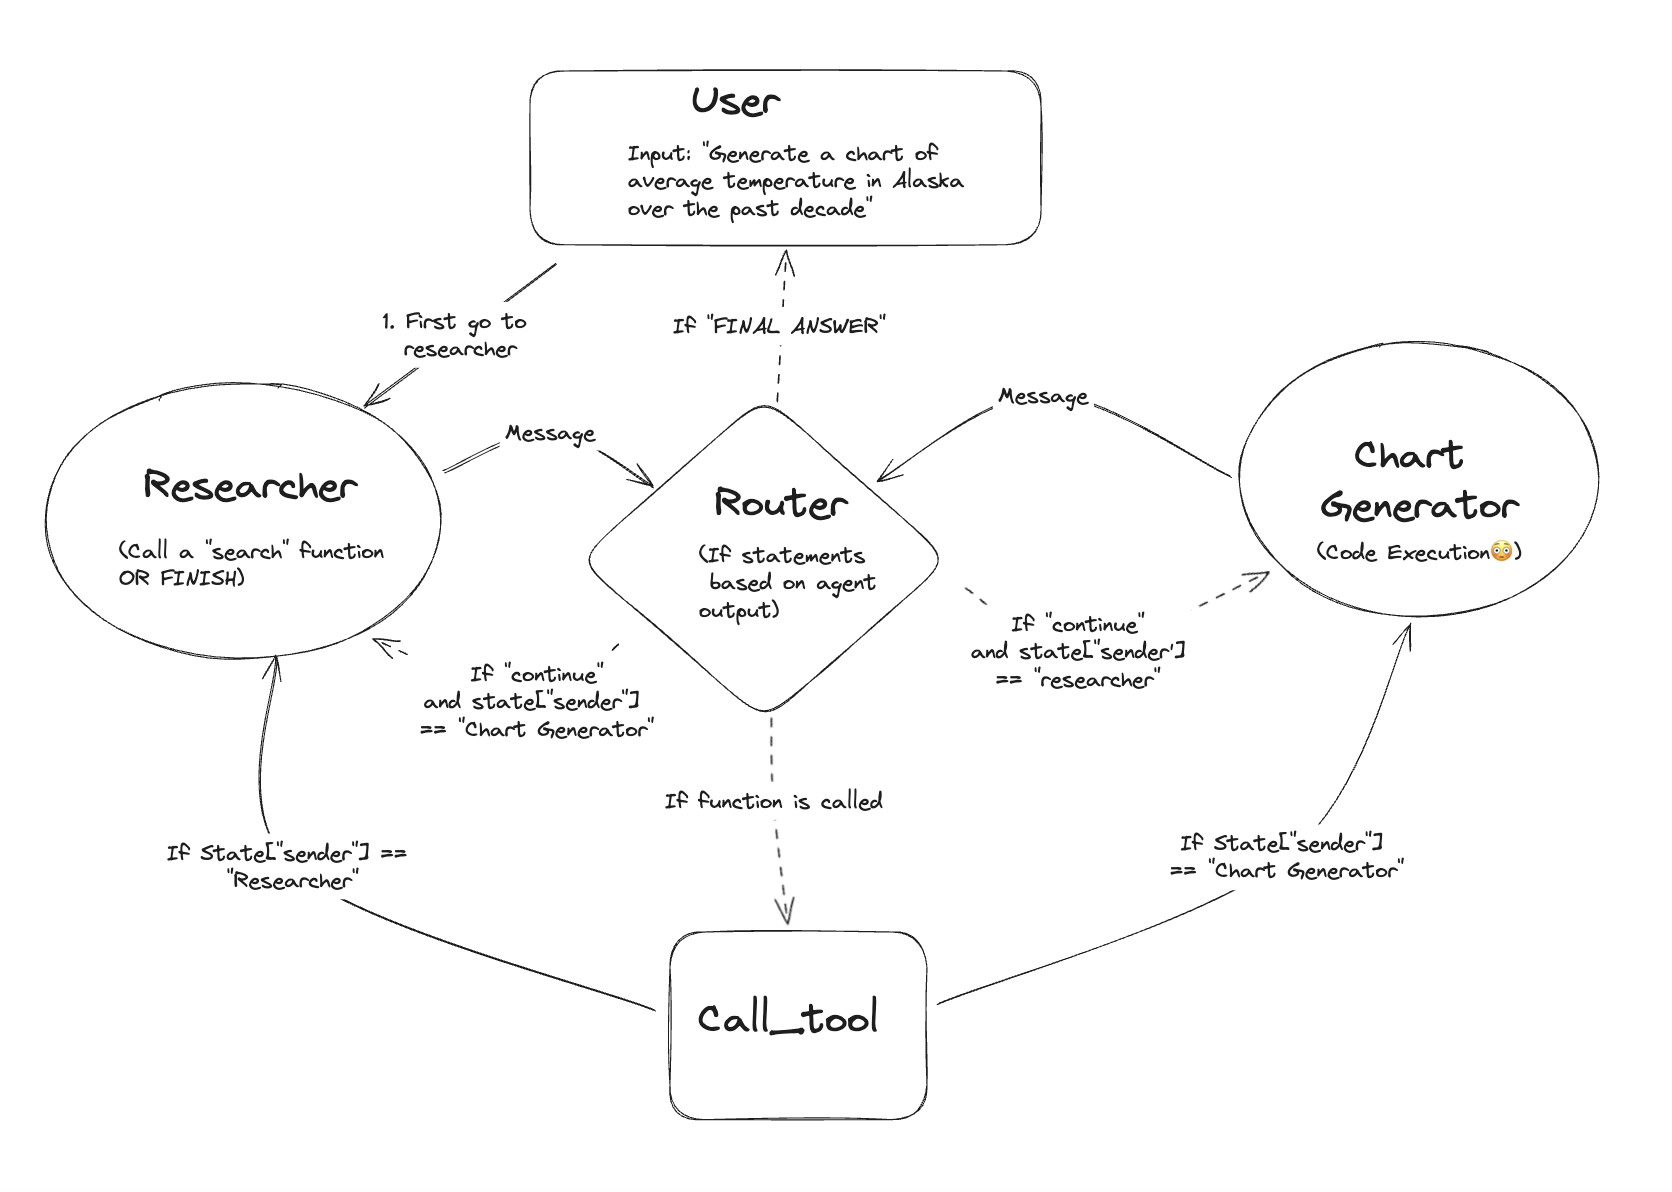

In [11]:
import json

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    functions = [format_tool_to_openai_function(t) for t in tools]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_functions(functions)

<h2>Define Tools</h2>

In [12]:
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Succesfully executed:\n```python\n{code}\n```\nStdout: {result}"

<h1>Create Agents</h1>

<h2>Define State</h2>

In [13]:
import operator
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union

from langchain.agents import create_openai_functions_agent
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

<h2>Define Agent Node</h2>

In [14]:
import functools


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, FunctionMessage):
        pass
    else:
        result = HumanMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4-1106-preview")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# Chart Generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart Generator")

/home/xerg/projects/llm-agents/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `format_tool_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 0.2.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


<h2>Define Tool Node</h2>

In [15]:
tools = [tavily_tool, python_repl]
tool_executor = ToolExecutor(tools)


def tool_node(state):
    """This runs tools in the graph

    It takes in an agent action and calls that tool and returns the result."""
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    tool_input = json.loads(
        last_message.additional_kwargs["function_call"]["arguments"]
    )
    # We can pass single-arg inputs by value
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(
        tool=tool_name,
        tool_input=tool_input,
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

<h2>Define Edge Logic</h2>

In [16]:
# Either agent can decide to end
def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "function_call" in last_message.additional_kwargs:
        # The previus agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "end"
    return "continue"

<h2>Define The Graph</h2>

In [17]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("Chart Generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "Chart Generator", "call_tool": "call_tool", "end": END},
)
workflow.add_conditional_edges(
    "Chart Generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "end": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "Chart Generator": "Chart Generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

<h2>Invoke</h2>

{'Researcher': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"Bangladesh GDP 2018 2019 2020 2021 2022"}', 'name': 'tavily_search_results_json'}}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 221, 'total_tokens': 256}, 'model_name': 'gpt-4-1106-preview', 'system_fingerprint': 'fp_94f711dcf6', 'finish_reason': 'function_call', 'logprobs': None}, name='Researcher', id='run-15c3f528-3427-4e08-b63b-30cf29080226-0', tool_calls=[], invalid_tool_calls=[])], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [FunctionMessage(content='tavily_search_results_json response: [{\'url\': \'https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?locations=BD\', \'content\': \'GDP growth (annual %) - Bangladesh. World Bank national accounts data, and OECD National Accounts data files. License : CC BY-4.0. LineBarMap. Also Show Share Details. Label. 1961 - 2022.\'}, {\'url\': \'https://tradingeconomics.com/banglades

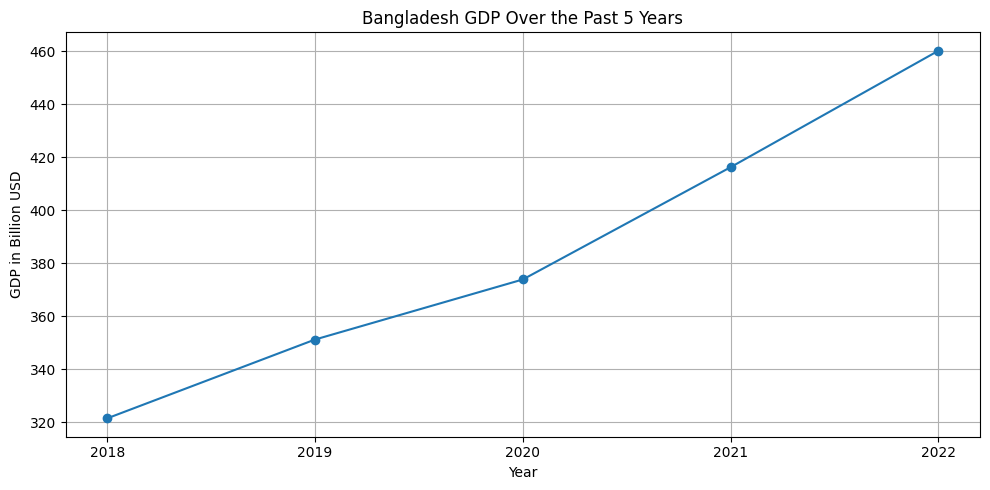

{'Chart Generator': {'messages': [HumanMessage(content="Now that we have the GDP values for Bangladesh from 2018 to 2022, I will generate a line graph to visualize the data. Let's proceed with creating the graph.", additional_kwargs={'function_call': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# GDP values for Bangladesh from 2018 to 2022\\nyears = [2018, 2019, 2020, 2021, 2022]\\ngdp_values = [321.51, 351.24, 373.90, 416.26, 460.20]\\n\\n# Create a line graph\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, gdp_values, marker=\'o\')\\nplt.title(\'Bangladesh GDP Over the Past 5 Years\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'GDP in Billion USD\')\\nplt.grid(True)\\nplt.xticks(years)\\nplt.tight_layout()\\nplt.show()"}', 'name': 'python_repl'}}, response_metadata={'token_usage': {'completion_tokens': 210, 'prompt_tokens': 1209, 'total_tokens': 1419}, 'model_name': 'gpt-4-1106-preview', 'system_fingerprint': 'fp_fb84c680ea', 'finish_reason': 'function_call', 'logprobs': No

BadRequestError: Error code: 400 - {'error': {'message': "'Chart Generator' does not match '^[a-zA-Z0-9_-]{1,64}$' - 'messages.5.name'", 'type': 'invalid_request_error', 'param': None, 'code': None}}

In [28]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the Bangladesh's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
        
        # "messages": [
        #     HumanMessage(
        #         content="Fetch the UK's GDP over the past 5 years,"
        #         " then draw a line graph of it."
        #         " Once you code it up, finish."
        #     )
        # ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
):
    print(s)
    print("----")

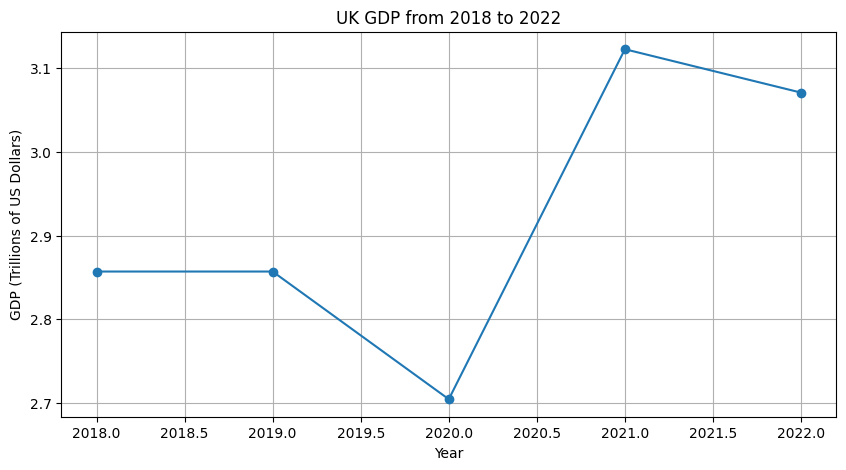

In [27]:
import matplotlib.pyplot as plt

# UK GDP in current US dollars for the years 2018-2022
years = [2018, 2019, 2020, 2021, 2022]
gdp_values = [2.85706, 2.85706, 2.70461, 3.12248, 3.07067]  # Trillions

def draw_line_graph(years, gdp_values, title, xlabel, ylabel):
    plt.figure(figsize=(10, 5))
    plt.plot(years, gdp_values, marker= 'o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Drawing the line graph
draw_line_graph(years, gdp_values, 'UK GDP from 2018 to 2022', 'Year', 'GDP (Trillions of US Dollars)')